In [3]:
!pwd

/Users/cmeena/Desktop/ML Practice/TensorFlow Developer/Aurelion Book/Ch 3


In [1]:
import numpy as np
import pandas as pd
import os
import sys

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape, y.shape)

(70000, 784) (70000,)


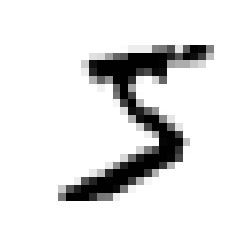

5


In [10]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt

index = 0
some_digit = X[index]
some_digit_image = some_digit.reshape(28, 28)
# plt.imshow(some_digit_image)
plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")
plt.show()

# convert y from string to numeric

y = y.astype(np.uint8)

print(y[index])

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### ***Training a binary classifier***- 5-detector

In [6]:
# True for all 5s and False for all non 5s

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

### Performance Measures

*Measuring Accuracy using Cross Validation*

In [8]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [11]:
# a dumb classifier that classifies every single image in the not-5 class

from sklearn.base import BaseEstimator

class Not5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype = bool)

not_5_classifier = Not5Classifier()
cross_val_score(not_5_classifier, X_train, y_train_5, cv = 3, scoring = "accuracy")

# accuracy is not a good measure when the data is this skewed (10% 5s v. 90% Not-5s)

array([0.91125, 0.90855, 0.90915])

*Confusion Matrix*

In [44]:
# to make confusion matrix we need to make prediction (but not on test data as of yet)

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [45]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

# each row is actual class
# each column is predicted class
# first row is negative class (true negative & false positive resp.)
# second row is positive class (false negative & true positive)

array([[53892,   687],
       [ 1891,  3530]])

In [46]:
# how a perfect classifier will look like

y_train_pred_perfect = y_train_5

confusion_matrix(y_train_5, y_train_pred_perfect)

array([[54579,     0],
       [    0,  5421]])

In [47]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)

print(precision, recall)

0.8370879772350012 0.6511713705958311


In [48]:
from sklearn.metrics import f1_score

f1 = f1_score(y_train_5, y_train_pred)
print(f1)

0.7325171197343846


*Precision-Recall trade off*

In [49]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [50]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [51]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [62]:
y_train_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

In [63]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train_5, y_train_scores)

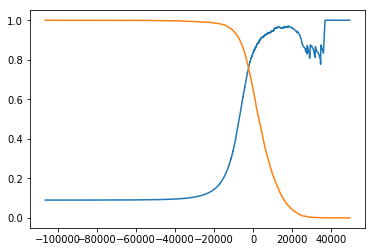

In [64]:
# Precision Recall against Threshold

def plot_precision_recall_v_threshold_curve(precision_, recall_, threshold_):
    plt.plot(threshold_, precision_[:-1], label = "Precison")
    plt.plot(threshold_, recall_[:-1], label = "Recall")
    
plot_precision_recall_v_threshold_curve(precision, recall, threshold)
plt.show()

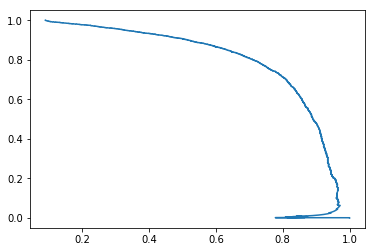

In [65]:
# Precision against Recall

def plot_precision_v_recall_curve(precision_, recall_):
    plt.plot(precision_, recall_)

plot_precision_v_recall_curve(precision, recall)
plt.show()

# precision starts to fall after 80% recall

In [66]:
threshold_90_precision = threshold[np.argmax(precision >= 90.0)]
threshold_90_precision

-106527.45300471177

In [67]:
threshold = 7000
y_train_scores_90 = (y_train_scores >= threshold)
y_train_scores_90

array([False, False, False, ...,  True, False, False])

In [68]:
precison_90_threshold = precision_score(y_train_5, y_train_scores_90)
recall_90_threshold = recall_score(y_train_5, y_train_scores_90)

print(precison_90_threshold, recall_90_threshold)

0.9308681672025724 0.32042058660763695


*ROC Curve*

In [81]:
from sklearn.metrics import roc_curve

tpr, fpr, threshold = roc_curve(y_train_5, y_train_scores)

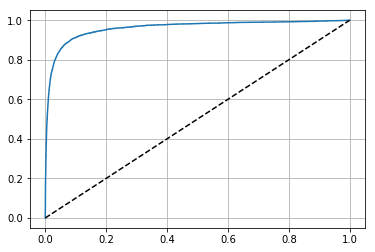

In [109]:
# ROC_curve

def plot_roc_curve(tpr_, fpr_, label = None):
    plt.plot(tpr_, fpr_, label = label)
    plt.plot((0,1),(0,1),'k--')
    
plot_roc_curve(tpr, fpr, "SGD")
plt.grid()
plt.show()

# higher the TPR (recall/sensitivity) -> higher will be the FPR 
# dotted line represents roc curve of a purely randome classifier
# a good classifier stays away from this dotted line as possible (towards the top left corner)

In [73]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_train_scores)

0.9604938554008616

In [74]:
# comparing SGDClassifier vs RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba")

In [77]:
y_probas_forest[:5]

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       [1.  , 0.  ],
       [0.99, 0.01]])

In [79]:
# picking only Positive class's probability as the score

y_scores_forest = y_probas_forest[:, 1]
y_scores_forest[:5]

array([0.89, 0.01, 0.04, 0.  , 0.01])

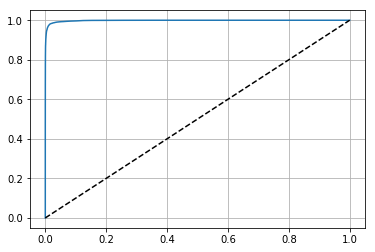

In [108]:
tpr_forest, fpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

plot_roc_curve(tpr_forest, fpr_forest, "Random Forest")
plt.grid()
plt.show()

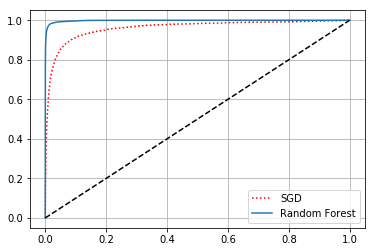

In [107]:
# plotting both SGD and RF ROC curve

plt.plot(tpr, fpr, "r:", label = "SGD")
plot_roc_curve(tpr_forest, fpr_forest, "Random Forest")
plt.legend(loc = "lower right")
plt.grid()
plt.show()

# Random Forest has a much better ROC curve than SGD

In [92]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

### ***Multiclass Classification***

In [111]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

# under the hood sklearn SVM uses OvO multiclass strategy

array([5], dtype=uint8)

In [112]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [113]:
np.argmax(some_digit_scores)

5

In [114]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [115]:
svm_clf.classes_[5]

5

In [116]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [117]:
len(ovr_clf.estimators_)

10

*Training SGD classifier on  Multiclass problem*

In [120]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [121]:
sgd_clf.decision_function([some_digit])

array([[-10967.35915852, -32125.99703917,  -6176.2688951 ,
          1539.26076442, -27999.57687788,   1592.96599943,
        -19515.50928413,  -9962.16793828, -10486.42847267,
        -12363.27355218]])

In [122]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.8553 , 0.84665, 0.86005])

In [125]:
# after standardizing training data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy")

array([0.89925, 0.89315, 0.90035])

### ***Error Analysis***

In [126]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5576,    0,   21,    6,    8,   43,   36,    5,  227,    1],
       [   1, 6402,   39,   23,    4,   44,    4,    8,  206,   11],
       [  27,   26, 5244,   90,   70,   27,   66,   38,  358,   12],
       [  23,   17,  118, 5211,    1,  206,   26,   41,  415,   73],
       [  12,   14,   46,   11, 5200,   13,   34,   25,  326,  161],
       [  27,   16,   31,  171,   50, 4441,   76,   15,  534,   60],
       [  30,   15,   44,    2,   43,   96, 5554,    4,  129,    1],
       [  21,   10,   51,   25,   49,   12,    3, 5694,  191,  209],
       [  18,   64,   48,   86,    3,  123,   25,   10, 5430,   44],
       [  22,   19,   30,   62,  117,   34,    1,  176,  365, 5123]])

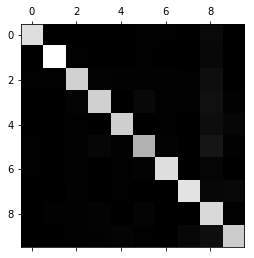

In [129]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

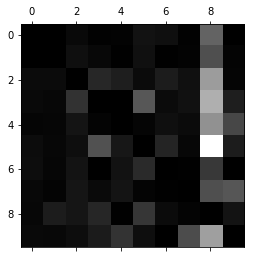

In [132]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx/row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

In [136]:
def plot_digits(instances, images_per_row = 10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instances.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1)//images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros(size, size*n_empty))
    for row in range(n_rows):
        rimages = images[row*images_per_row : (row+1)*images_per_row]
        row_images.append(np.concatenate(rimages, axis = 0))
        plt.imshow(image, cmap = mlp.cm.binary, **options)
        plt.axis("off")

In [138]:
cl_a, cl_b = 3, 5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize = (8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row = 5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row = 5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row = 5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row = 5)

plt.show()

### ***Multilabel Classification***

In [141]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[False,  True]])

In [142]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average = "macro")

0.976410265560605